### E25. Spectrogram Classification

- 목표
    - Audio 형태의 데이터를 다루는 방법에 대해서 알아보기
    - Wav 파일의 형태와 원리를 이해하기 
    - 오디오데이터를 다른 다양한 형태로 변형시켜보기 
    - 차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import librosa
import librosa.display

#### 1. 데이터 로드 및 전처리 

In [8]:
data_path = os.getenv("HOME") + '/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [9]:
print(f"Wave data shape : {speech_data['wav_vals'].shape}")
print(f"Label data shape : {speech_data['label_vals'].shape}")

Wave data shape : (50620, 8000)
Label data shape : (50620, 1)


In [10]:
rand = random.randint(0, len(speech_data['wav_vals']))
print(f"rand num : {rand}")

sr = 8000
data = speech_data['wav_vals'][rand]
print(f"Wave data shape : {data.shape}")
print(f"label : {speech_data['label_vals'][rand]}")

ipd.Audio(data, rate=sr)

rand num : 35310
Wave data shape : (8000,)
label : ['right']


##### 1.1 Text라벨 index 변환

In [11]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value
label_value

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

In [12]:
temp = []
for v in speech_data['label_vals']:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data

array([ 3,  3,  3, ..., 11, 11, 11])

##### 1.2 Train, Test 데이터 분리 

In [13]:
sr = 8000

train_wav, test_wav, train_label, test_label = train_test_split(speech_data['wav_vals'], label_data, test_size=0.1, shuffle=True)

print(train_wav)


[[ 2.77239154e-03  4.09618625e-03  5.18471526e-04 ...  5.59138041e-03
   4.88450006e-03  2.75988481e-04]
 [ 1.62114497e-06  6.37076228e-05  6.00096719e-05 ... -4.29184620e-05
  -2.31448175e-05 -5.90954405e-05]
 [ 1.09322171e-03 -2.54688542e-02 -2.63706576e-02 ... -3.85202393e-02
  -1.74130350e-02 -2.87703617e-04]
 ...
 [ 5.15986503e-05  5.42790731e-05  1.02632795e-04 ...  1.66367507e-04
   2.13557083e-04  5.13330742e-04]
 [-1.52121310e-03 -2.75197555e-03 -1.75987347e-03 ...  1.05423278e-05
   7.66451703e-04  4.39998042e-03]
 [-3.97004187e-05 -9.57296379e-06  1.66761515e-06 ...  1.60088879e-04
   1.28369953e-04  1.55493704e-04]]


In [14]:
train_wav

array([[ 2.77239154e-03,  4.09618625e-03,  5.18471526e-04, ...,
         5.59138041e-03,  4.88450006e-03,  2.75988481e-04],
       [ 1.62114497e-06,  6.37076228e-05,  6.00096719e-05, ...,
        -4.29184620e-05, -2.31448175e-05, -5.90954405e-05],
       [ 1.09322171e-03, -2.54688542e-02, -2.63706576e-02, ...,
        -3.85202393e-02, -1.74130350e-02, -2.87703617e-04],
       ...,
       [ 5.15986503e-05,  5.42790731e-05,  1.02632795e-04, ...,
         1.66367507e-04,  2.13557083e-04,  5.13330742e-04],
       [-1.52121310e-03, -2.75197555e-03, -1.75987347e-03, ...,
         1.05423278e-05,  7.66451703e-04,  4.39998042e-03],
       [-3.97004187e-05, -9.57296379e-06,  1.66761515e-06, ...,
         1.60088879e-04,  1.28369953e-04,  1.55493704e-04]], dtype=float32)

In [15]:
print(f"train data : {train_wav.shape}")
print(f"train label : {train_label.shape}")
print(f"test data : {test_wav.shape}")
print(f"test label : {test_label.shape}")


train data : (45558, 8000)
train label : (45558,)
test data : (5062, 8000)
test label : (5062,)


In [16]:
batch_size = 128
max_epochs = 10

checkpoint_dir = os.getenv("HOME") + "/aiffel/speech_recognition/models/wav"

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

In [17]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth = 12)
    return wav, label

In [18]:
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    D = np.expand_dims(D, axis = -1)
    return D

##### 1.3 Spectrogram 변환

In [19]:
train_spec = []
test_spec = []
for train in train_wav:
    train_spec.append(wav2spec(train))
    
for test in test_wav:
    test_spec.append(wav2spec(test))

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.repeat().batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


#### 2. 모델 구성 및 학습 

##### 2.1 기본 모델 

In [21]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 31, 64)       

In [22]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])

In [23]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

In [24]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs, steps_per_epoch=len(train_wav)//batch_size, validation_data=test_dataset, 
                            validation_steps=len(test_wav)//batch_size, callbacks=[cp_callback])

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.0055 - accuracy: 0.6793
Epoch 00001: val_loss improved from inf to 0.86434, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 53s 150ms/step - loss: 1.0055 - accuracy: 0.6793 - val_loss: 0.8643 - val_accuracy: 0.8582
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.3423 - accuracy: 0.8965
Epoch 00002: val_loss improved from 0.86434 to 0.29783, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 55s 154ms/step - loss: 0.3423 - accuracy: 0.8965 - val_loss: 0.2978 - val_accuracy: 0.9099
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.2207 - accuracy: 0.9353
Epoch 00003: val_loss improved from 0.29783 to 0.21898, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
355/355 [==============================] - 54s 152ms/step - loss: 0.2207 - accurac

##### 2.2 Skip connection 추가 버전 

In [35]:
input_tensor = layers.Input(shape=(130,126,1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 130, 126, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 130, 126, 32) 9248        conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 65, 63, 32)   0           conv2d_31[0][0]                  
_______________________________________________________________________________________

In [26]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])

In [27]:
checkpoint_dir_skip = os.getenv('HOME') + '/aiffel/speech_recognition/models/wav_skip'

cp_callback_skip = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir_skip, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)

In [28]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs, steps_per_epoch=len(train_wav)//batch_size, validation_data=test_dataset, 
                            validation_steps=len(test_wav)//batch_size, callbacks=[cp_callback_skip])

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.6513
Epoch 00001: val_loss improved from inf to 0.49493, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 59s 166ms/step - loss: 1.0972 - accuracy: 0.6513 - val_loss: 0.4949 - val_accuracy: 0.8658
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8950
Epoch 00002: val_loss improved from 0.49493 to 0.31714, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 60s 168ms/step - loss: 0.3491 - accuracy: 0.8950 - val_loss: 0.3171 - val_accuracy: 0.9036
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9349
Epoch 00003: val_loss improved from 0.31714 to 0.23696, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 60s 170ms/step - loss: 0

#### 3. 시각화

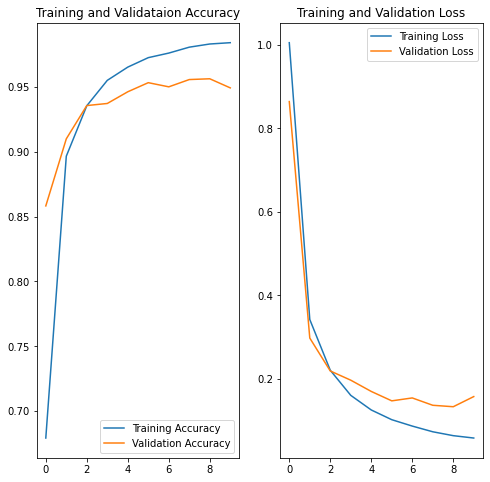

In [29]:
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss = history_wav.history['loss']
val_loss = history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validataion Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
model_wav.load_weights(checkpoint_dir)

In [31]:
results = model_wav.evaluate(test_dataset, steps = len(test_wav) // batch_size)

39/39 [==============================] - 2s 48ms/step - loss: 0.1333 - accuracy: 0.9561


In [32]:
print(f"loss value : {results[0]}")
print(f"accuracy value : {results[1]*100}")

loss value : 0.13332827389240265
accuracy value : 95.6129789352417


**Waveform 데이터를 입력으로 받아 Conv1D학습을 하는 것보다 Spectrogram 데이터를 입력으로 받아 Conv2D학습을 하는 것이 더 좋은 결과를 내는 것을 확인할 수 있다.**

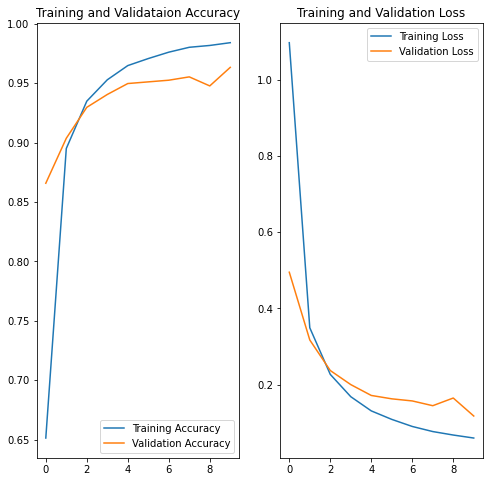

In [33]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss = history_wav_skip.history['loss']
val_loss = history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validataion Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model_wav_skip.load_weights(checkpoint_dir_skip)
results = model_wav_skip.evaluate(test_dataset, steps=len(test_wav)//batch_size)


print(f"loss value : {results[0]}")
print(f"accuracy value : {results[1]*100}")

39/39 [==============================] - 2s 52ms/step - loss: 0.1176 - accuracy: 0.9633
loss value : 0.11760711669921875
accuracy value : 96.33413553237915


**Skip-connection을 추가한 버전이 layer층을 더 많이 쌓지는 않아도 더 좋은 성능을 내는 것을 확인할 수 있다.**

#### 4. 고찰 

- 처음에는 시간에 따른 파형을 Spectogram으로 변환하여 2차원으로 학습을 시키는 경우 연속적인 시간에 따른 정보가 왜곡되는 것이 아닐지 고민을 하였지만 Spectrogam의 형태와 Convolution의 원리를 이해하니 모델의 학습방법을 이해할 수 있었다. 
- 학습을 위한 데이터 변환의 중요성과 데이터가 변환된 경우 모델을 변경하는 방법에 대해서 배울 수 있었다. 